**Toxic Comments predictive model based on a Neural Network and Principal Components Analysis**

This project is made using a dataset of comments from Wikipedia’s talk page edits (avaible on https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge). The model presented here is capable of detecting different types of of toxicity like threats, obscenity, insults, and identity-based hate. To reduce de dimensionality of the dataset i use a technique known as 'PCA'. Also a comparation between using this technique or not it's presented.

### Importing useful libraries


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import seaborn as sns

###Loading the dataset

In [ ]:
# google drive
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [ ]:
# Verify account
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
#ID to obtain "toxic_train" (I only going to work with this dataset at moment to verify the accuracy of model)
downloaded = drive.CreateFile({'id':'1r6ahWncTbMnSkXfIFzSwnFHHLWa_G2JQ'}) 
downloaded.GetContentFile('toxic_train.csv') 
train = pd.read_csv('toxic_train.csv')

### Basic information of dataset

In [ ]:
train.shape

(159571, 8)

In [ ]:
num_data=5000 # This is for make a model with a small dataset and not satured the RAM avaible here in google colab.

In [ ]:
train.columns

Index(['id', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat',
       'insult', 'identity_hate'],
      dtype='object')

In [ ]:
train.head(2)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0


### Preparing dataset

In [ ]:
labels=['toxic', 'severe_toxic', 'obscene', 'threat',
       'insult', 'identity_hate']
y=train[labels][:num_data]

In [ ]:
comments=train['comment_text'][:num_data]

In [ ]:
comments[0] # Jus an example of only a single comment

"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27"

### Cleaning dataset

In [ ]:
import nltk
nltk.download('stopwords')
# To remove words just as 'the','of','on'
from nltk.corpus import stopwords
# Regular expressions managing
import re

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
def clean_text(text, remove_stopwords=True):
  output=""
  text=str(text).replace("\n"," ")
  # Unicode characters remove
  text=re.sub(r'[^\w\s]','',text).lower()
  text=re.sub(r'[^a-z ]','',text)

  if remove_stopwords:
    text=text.split(" ")
    for word in text:
      if word not in stopwords.words("english"):
        output=output + " " + word
  else:
    output=text
  return str(output.strip()).replace(" "," ")

In [ ]:
# text contains the same dataset but with the 'cleaned' information
text = []
for line in comments:
  text.append(clean_text(line))

In [ ]:
comments[0] # Before

"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27"

In [ ]:
text[0] # After

'explanation edits made username hardcore metallica fan reverted werent vandalisms closure gas voted new york dolls fac please dont remove template talk page since im retired'

### Categorical transformation of text

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer # To generate a sparse matrix

In [ ]:
vectorizer=CountVectorizer()
X=vectorizer.fit_transform(text)

In [ ]:
X

<5000x24808 sparse matrix of type '<class 'numpy.int64'>'
	with 138960 stored elements in Compressed Sparse Row format>

The dimension of 'text' is now: 24808. Let's train this dataset without dimensionality reduction (PCA).

### Training and testing dataset



In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 10)

In [ ]:
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((4000, 24808), (1000, 24808), (4000, 6), (1000, 6))

### Standardization

In [ ]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [ ]:
sc_X =  StandardScaler(with_mean=False) # Neccesary to call the StandarScaler funcion with this argument
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.transform(X_test)

### Validation and testing dataset

In [ ]:
X_test, X_valid, y_test, y_valid = train_test_split(X_test,y_test,test_size=0.2,random_state=10)

### Neural Network

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.layers import Dense, Activation
from keras.models import Sequential

In [ ]:
model1 = Sequential()
model1.add(Dense(2000,input_dim=X_train.shape[1],activation='sigmoid'))
model1.add(Dense(1400,activation='relu'))
model1.add(Dense(600,activation='relu'))
model1.add(Dense(y.shape[1],activation='sigmoid'))
model1.compile(optimizer='Adam',loss='binary_crossentropy',metrics=['accuracy'])

In [ ]:
y_train = np.asarray(y_train)
y_valid = np.asarray(y_valid)

In [ ]:
history=model1.fit(X_train,y_train,batch_size=32,epochs=50,validation_data=(X_valid,y_valid))

Epoch 1/50
125/125 [==============================] - 2s 12ms/step - loss: 1.9486e-07 - accuracy: 0.1515 - val_loss: 0.4513 - val_accuracy: 0.3450
Epoch 2/50
125/125 [==============================] - 2s 12ms/step - loss: 1.7657e-07 - accuracy: 0.1507 - val_loss: 0.4538 - val_accuracy: 0.3450
Epoch 3/50
125/125 [==============================] - 1s 12ms/step - loss: 1.6043e-07 - accuracy: 0.1507 - val_loss: 0.4571 - val_accuracy: 0.3450
Epoch 4/50
125/125 [==============================] - 1s 12ms/step - loss: 1.4767e-07 - accuracy: 0.1535 - val_loss: 0.4592 - val_accuracy: 0.3450
Epoch 5/50
125/125 [==============================] - 2s 12ms/step - loss: 1.3259e-07 - accuracy: 0.1532 - val_loss: 0.4619 - val_accuracy: 0.3400
Epoch 6/50
125/125 [==============================] - 2s 12ms/step - loss: 1.2091e-07 - accuracy: 0.1560 - val_loss: 0.4639 - val_accuracy: 0.3500
Epoch 7/50
125/125 [==============================] - 1s 12ms/step - loss: 1.0801e-07 - accuracy: 0.1567 - val_loss: 0

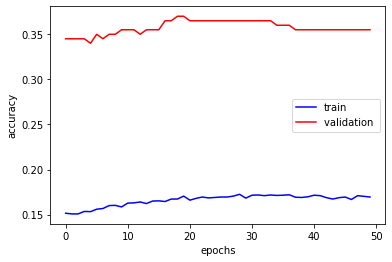

In [ ]:
plt.plot(history.history['accuracy'],color='b',label='train')
plt.plot(history.history['val_accuracy'],color='r',label='validation ')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

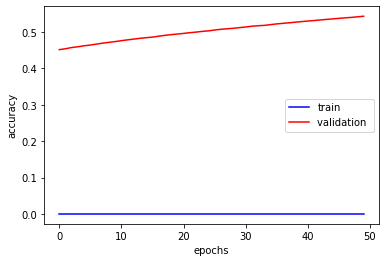

In [ ]:
plt.plot(history.history['loss'],color='b',label='train')
plt.plot(history.history['val_loss'],color='r',label='validation ')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

### Evaluation of the model without using PCA

In [ ]:
y_test=y_test.values

In [ ]:
y_pred=model1.predict(X_test)

In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
for i in range(y_test.shape[1]):
  cm=confusion_matrix(y_test[:,i],y_pred[:,i]>0.5)
  print(labels[i],'\n',cm,'\n')

toxic 
 [[700  10]
 [ 44  46]] 

severe_toxic 
 [[786   5]
 [  6   3]] 

obscene 
 [[751   2]
 [ 19  28]] 

threat 
 [[797   1]
 [  2   0]] 

insult 
 [[745   5]
 [ 26  24]] 

identity_hate 
 [[790   2]
 [  6   2]] 



## Same model but using PCA

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
pca = PCA(0.9)

In [ ]:
X_pca = pca.fit_transform(X.toarray())

In [ ]:
X_pca.shape

(5000, 323)

Now i have 323 features instead of 24808!

### Training and testing dataset

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size = 0.2, random_state = 10)

In [ ]:
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((4000, 323), (1000, 323), (4000, 6), (1000, 6))

#### Standardization

In [ ]:
sc_X =  StandardScaler(with_mean=False) 
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.transform(X_test)

#### Validation and testing dataset

In [ ]:
X_test, X_valid, y_test, y_valid = train_test_split(X_test,y_test,test_size=0.2,random_state=10)

#### Neural Network

In [ ]:
model2 = Sequential()
model2.add(Dense(2000,input_dim=X_train.shape[1],activation='sigmoid'))
model2.add(Dense(1400,activation='relu'))
model2.add(Dense(600,activation='relu'))
model2.add(Dense(y.shape[1],activation='sigmoid'))
model2.compile(optimizer='Adam',loss='binary_crossentropy',metrics=['accuracy'])

In [ ]:
y_train = np.asarray(y_train)
y_valid = np.asarray(y_valid)

In [ ]:
history2=model2.fit(X_train,y_train,batch_size=32,epochs=50,validation_data=(X_valid,y_valid))

Epoch 1/50
125/125 [==============================] - 1s 4ms/step - loss: 0.2685 - accuracy: 0.5026 - val_loss: 0.1378 - val_accuracy: 0.9700
Epoch 2/50
125/125 [==============================] - 0s 3ms/step - loss: 0.1074 - accuracy: 0.7949 - val_loss: 0.1129 - val_accuracy: 0.9900
Epoch 3/50
125/125 [==============================] - 0s 3ms/step - loss: 0.0945 - accuracy: 0.9148 - val_loss: 0.1125 - val_accuracy: 0.9850
Epoch 4/50
125/125 [==============================] - 0s 3ms/step - loss: 0.0947 - accuracy: 0.8667 - val_loss: 0.1109 - val_accuracy: 0.9900
Epoch 5/50
125/125 [==============================] - 0s 3ms/step - loss: 0.0863 - accuracy: 0.9042 - val_loss: 0.1001 - val_accuracy: 0.9900
Epoch 6/50
125/125 [==============================] - 0s 3ms/step - loss: 0.0896 - accuracy: 0.9290 - val_loss: 0.1027 - val_accuracy: 0.9750
Epoch 7/50
125/125 [==============================] - 0s 3ms/step - loss: 0.0779 - accuracy: 0.9426 - val_loss: 0.1029 - val_accuracy: 0.4150
Epoch 

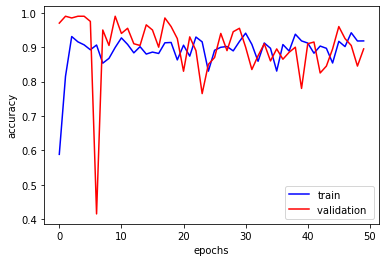

In [ ]:
plt.plot(history2.history['accuracy'],color='b',label='train')
plt.plot(history2.history['val_accuracy'],color='r',label='validation ')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

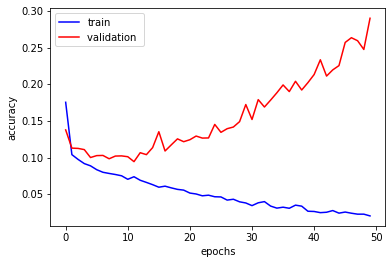

In [ ]:
plt.plot(history2.history['loss'],color='b',label='train')
plt.plot(history2.history['val_loss'],color='r',label='validation ')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

#### Evaluation of the model using PCA

In [ ]:
y_test=y_test.values

In [ ]:
model2.evaluate(X_test,y_test)

25/25 [==============================] - 0s 2ms/step - loss: 0.3021 - accuracy: 0.9050


[0.3021005690097809, 0.9049999713897705]

In [ ]:
y_pred=model2.predict(X_test)

In [ ]:
for i in range(y_test.shape[1]):
  cm=confusion_matrix(y_test[:,i],y_pred[:,i]>0.5)
  print(labels[i],'\n',cm,'\n')

toxic 
 [[682  28]
 [ 41  49]] 

severe_toxic 
 [[783   8]
 [  8   1]] 

obscene 
 [[728  25]
 [ 23  24]] 

threat 
 [[798   0]
 [  2   0]] 

insult 
 [[730  20]
 [ 28  22]] 

identity_hate 
 [[789   3]
 [  8   0]] 



### Conclusions

The next figure shows that the model without using PCA it's completely a bad model, this was configured using the same hyperparameters that *model2* uses. Therefore using Principal Components Analisys allow us to work with a minimun features and increase the accuracy of a model.

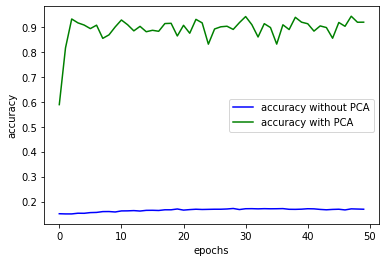

In [ ]:
plt.plot(history.history['accuracy'],color='b',label='accuracy without PCA')
plt.plot(history2.history['accuracy'],color='g',label='accuracy with PCA')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()